In [7]:
import cv2 as cv
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from transformers import CLIPProcessor, CLIPModel

from gen_images import make_transform
import os
import re
from typing import List, Optional, Tuple, Union

import click
import dnnlib
import numpy as np
import PIL.Image
import torch
from scipy import fftpack
from werkzeug.utils import secure_filename

import legacy

import io
import base64

from sklearn.decomposition import PCA

network_pkl = "models/stylegan3-r-ffhq-1024x1024.pkl"
seeds = [1]
truncation_psi = 0.6
class_idx = None
noise_mode = "const"
outdir = "server_outputs"
translate = (0.0, 0.0)
rotate = 0.0
G = None

def generate_image(latent_vector):
    global G
    device = torch.device('cuda')
    if G is None:
        with dnnlib.util.open_url(network_pkl) as f:
            G = legacy.load_network_pkl(f)['G_ema'].to(device) # type: ignore
    os.makedirs(outdir, exist_ok=True)

    label = torch.zeros([1, G.c_dim], device=device)
    if G.c_dim != 0:
        if class_idx is None:
            raise click.ClickException('Must specify class label with --class when using a conditional network')
        label[:, class_idx] = 1
    else:
        if class_idx is not None:
            print ('warn: --class=lbl ignored when running on an unconditional network')

    for seed_idx, seed in enumerate(seeds):
        z = torch.from_numpy(latent_vector).to(device)
        if hasattr(G.synthesis, 'input'):
            m = make_transform(translate, rotate)
            m = np.linalg.inv(m)
            G.synthesis.input.transform.copy_(torch.from_numpy(m))
        img = G(z, label, truncation_psi=truncation_psi, noise_mode=noise_mode)
        img = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
        np_img = img[0].cpu().numpy()
        if len(np_img.shape) < 3 or np_img.shape[-1] < 3:
            np_img = np.stack([np_img[:, :, 0]]*3, axis=-1)
        return np_img

In [6]:
# Uncomment if you are running for the first time from stylegan docker
# !pip install scikit-learn
# !pip install transformers
# !pip install ipywidgets
# !pip install IProgress

In [8]:
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")



def smart_search(initial_latent, target_index, classes=["male, masculine", "female, feminine", "old", "young"], min_steps = 10, init_noise_scale=0.1, min_score=0.5):
    best_score = None
    best_latent = None
    
    noise_scale = init_noise_scale
    
    searching = True
    steps_taken = 0

    images, latents = [], []

    while steps_taken < min_steps or (best_score is not None and best_score < min_score):
        # Choose a very small random vector as step
        noise = np.random.normal(loc=0, scale=noise_scale, size=(1, 512))
        noisy_latent = initial_latent + noise

        noisy_image = generate_image(noisy_latent)
        noisy_fullscale_image = noisy_image.copy()
        noisy_image = cv.resize(noisy_image, (512, 512))
        
        inputs = processor(text=classes, images=np.array([noisy_image]), return_tensors="pt", padding=True)
        all_logits = model(**inputs).logits_per_image.softmax(1).detach().numpy()
        score = all_logits[0][target_index]

        if best_latent is None or score > best_score:
            best_score = score
            best_latent = noisy_latent
            images.append(noisy_fullscale_image)
            latents.append(noisy_latent)
            initial_latent = best_latent
            noise_scale = noise_scale * 0.99
            steps_taken += 1
            print("Best score so far: ", best_score)
            plt.imshow(noisy_fullscale_image)
            plt.show()
        else:
            noise_scale *= 1.0001
    return images, latents
        

Best score so far:  0.8841503


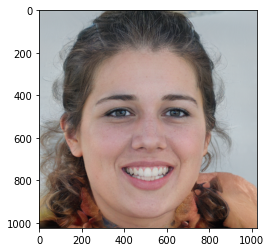

Best score so far:  0.97272766


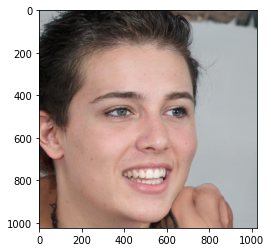

Best score so far:  0.9900738


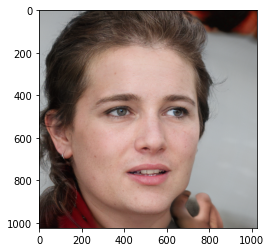

Best score so far:  0.9930092


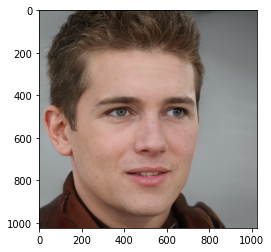

Best score so far:  0.99436706


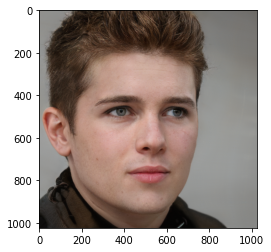

Best score so far:  0.997136


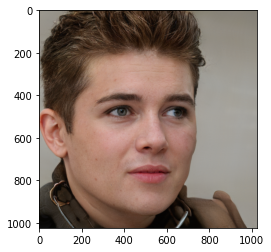

Best score so far:  0.99773836


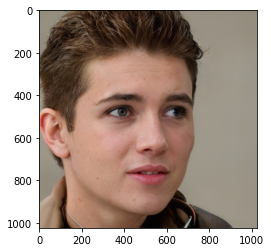

In [76]:
images, latents = smart_search(np.random.normal(size=(1, 512), loc=0, scale=truncation_psi*0.5), 0, init_noise_scale=3.1, min_steps=10, min_score=0.5, classes=[
    "young, beautiful",
    "old, ugly",
])

In [22]:
images = []
latents = []

for i in range(100):
    latent = np.random.normal(size=(1,512), loc=0, scale=truncation_psi)
    image = generate_image(latent)
    images.append(image)
    latents.append(latent[0])

In [110]:
np_images = np.array(images)

In [5]:
# Uncomment if you are running for the first time from stylegan docker
# !pip install ipywidgets
# !pip install IProgress

  Using cached ipywidgets-8.1.0-py3-none-any.whl (139 kB)
  Using cached comm-0.1.4-py3-none-any.whl (6.6 kB)
  Using cached jupyterlab_widgets-3.0.8-py3-none-any.whl (214 kB)
  Using cached widgetsnbextension-4.0.8-py3-none-any.whl (2.3 MB)
  Using cached IProgress-0.4-py3-none-any.whl (11 kB)


In [2]:

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

In [113]:
processing_batch_size = 25
current_batch = []
results = []
for image in images:
    if len(current_batch) < processing_batch_size:
        current_batch.append(image)
    if len(current_batch) == processing_batch_size:
        inputs = processor(text=["male, masculine", "female, feminine", "old", "young"], images=np.array(current_batch), return_tensors="pt", padding=True)
        all_logits = model(**inputs).logits_per_image.detach().numpy()
        for i in range(all_logits.shape[0]):
            results.append(all_logits[i])
        current_batch = []


In [114]:
np_results = np.array(results)

In [115]:
np_results.shape

(500, 4)

In [116]:
male_old = np.array([
    np_results[:, 0]-np_results[:, 1],
    np_results[:, 2]-np_results[:, 3],
]).T

In [117]:
male_old.shape

(500, 2)

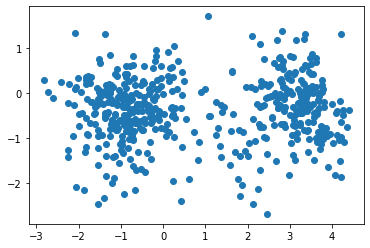

In [118]:
plt.scatter(male_old[:, 0], male_old[:, 1])

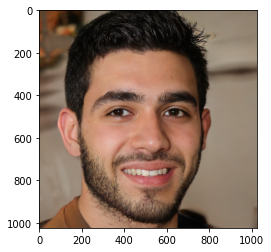

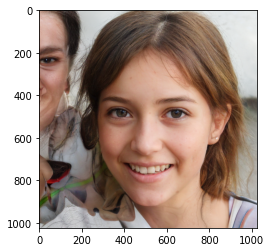

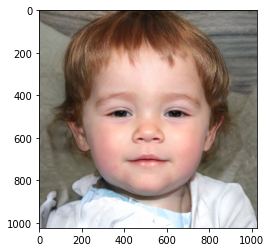

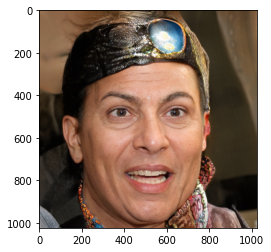

In [119]:
male_index = np.argmax(male_old[:, 0])
female_index = np.argmin(male_old[:, 0])
old_index = np.argmax(male_old[:, 1])
young_index = np.argmin(male_old[:, 1])

male_latent = latents[male_index]
female_latent = latents[female_index]
old_latent = latents[old_index]
young_latent = latents[young_index]

plt.imshow(images[male_index])
plt.show()

plt.imshow(images[female_index])
plt.show()

plt.imshow(images[young_index])
plt.show()

plt.imshow(images[old_index])
plt.show()

In [121]:
grid_size = (10, 10)
image_grid = []
all_interpolated_latents = []
for x in np.linspace(0.0, 1.0, grid_size[0]):
    image_column = []
    x_latent = male_latent + x*(female_latent-male_latent)
    for y in np.linspace(0.0, 1.0, grid_size[1]):
        y_latent = old_latent + y * (young_latent-old_latent)
        actual_latent = (x_latent + y_latent)
        all_interpolated_latents.append(actual_latent)
        image = generate_image(np.array([actual_latent]))/255.0
        image_column.append(image)
    image_grid.append(image_column)

(5120, 5120, 3)


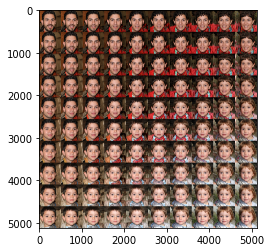

In [122]:
collage_img_size = 512
collage_size = (grid_size[0]*collage_img_size, grid_size[1]*collage_img_size)

collage = np.zeros((*collage_size, 3))
print(collage.shape)
for ix, col in enumerate(image_grid):
    for iy, img in enumerate(col):
        #plt.imshow(img)
        #plt.show()
        scaled_img = cv.resize(img, (collage_img_size, collage_img_size))
        collage[iy*collage_img_size:(iy+1)*collage_img_size, ix*collage_img_size:(ix+1)*collage_img_size] = scaled_img
plt.imshow(collage)

In [123]:
cv.imwrite("collage.png", collage[:, :, ::-1]*255.0)

True

In [34]:
def get_latent(x):
    scales = np.linspace(0.01, 1, 512)**2
    return np.sin((x)*scales)*truncation_psi

In [80]:
grid_size = (30, 30)
image_grid = []
for x in np.linspace(0.0, 1.0, grid_size[0]):
    image_column = []
    for y in np.linspace(0.0, 1.0, grid_size[1]):
        cx, cy = 0.5, 0.5
        dx = x-cx
        dy = y-cy
        dy *= -1
        radius = ((dx)**2 + (dy)**2)**0.5
        theta = np.arctan2(dy/radius, dx/radius)
        actual_latent = get_latent(radius*10*np.pi)
        rotate = np.rad2deg(theta + 90)
        image = generate_image(np.array([actual_latent]))/255.0
        image_column.append(image)
    image_grid.append(image_column)

: 

: 

: 

(1280, 1280, 3)


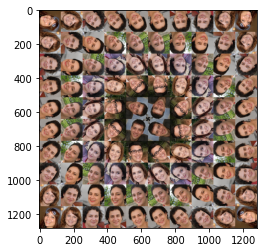

In [ ]:
collage_img_size = 128
collage_size = (grid_size[0]*collage_img_size, grid_size[1]*collage_img_size)

collage = np.zeros((*collage_size, 3))
print(collage.shape)
for ix, col in enumerate(image_grid):
    for iy, img in enumerate(col):
        scaled_img = cv.resize(img, (collage_img_size, collage_img_size))
        collage[iy*collage_img_size:(iy+1)*collage_img_size, ix*collage_img_size:(ix+1)*collage_img_size] = scaled_img
plt.imshow(collage)

In [ ]:
cv.imwrite("collage_rot_big.png", collage[:, :, ::-1]*255.0)

True